In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from random import sample
from skimage.util import random_noise
from skimage.transform import resize
from sklearn.model_selection import train_test_split # split training and testing dataset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio
from torch.utils.data import Dataset
import torchvision

In [2]:
# def MatLoader(data_dir):
#     mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
#     mat_data    = []
#     for f in mat_files:
#             # ---
#             st = data_dir + '/' + f
#             mat = scipy.io.loadmat(st)
#             data = np.array(mat['im'])
#             data = resize(data,(256,256))
#             data.shape = (data.shape[0],data.shape[1],1)
#             mat_data.append(np.transpose(data,(2,0,1)))
#             # ---
#     return np.double(np.concatenate(mat_data[:],axis=0))
# def MatLoaderN(data_dir):
#     mat_files   = [f for f in os.listdir(data_dir) if f.endswith('.mat')]
#     mat_data    = []
#     for f in mat_files:
#             # ---
#             st = data_dir + '/' + f
#             mat = scipy.io.loadmat(st)
#             data = np.array(mat['nim'])
#             data = resize(data,(256,256))
#             data.shape = (data.shape[0],data.shape[1],1)
#             mat_data.append(np.transpose(data,(2,0,1)))
#             # ---
#     return np.double(np.concatenate(mat_data[:],axis=0))

# data_dir = 'C:/Users/wnewm/NeuralNetworks_python/TrueTrain2' # Put your own data directory here
# data_dirLN = 'C:/Users/wnewm/NeuralNetworks_python/NoisyLow2'
# # data_dirMN = 'D:/QC500/NoisyMid'
# # data_dirHN = 'D:/QC500/NoisyHigh'
# GT   = MatLoader(data_dir) 
# LN   = MatLoaderN(data_dirLN) 
# print(GT.shape)  
# print(LN.shape)


In [3]:
# st = 'C:/Users/wnewm/NeuralNetworks_python/I.mat'
# mat = scipy.io.loadmat(st)
# data = np.array(mat['I'])
# data = resize(data,(256,256))
# data.shape = (data.shape[0],data.shape[1],1)
# data = data/np.max(data)
# LN = (np.concatenate((np.transpose(data,(2,0,1)),np.transpose(data,(2,0,1))),axis=0))
# st = 'C:/Users/wnewm/NeuralNetworks_python/obj.mat'
# mat = scipy.io.loadmat(st)
# data2 = np.array(mat['obj'])
# data2 = resize(data2,(256,256))
# data2 = data2/np.max(data2)
# data2.shape = (data2.shape[0],data2.shape[1],1)
# GT = np.double(np.concatenate((np.transpose(data2,(2,0,1)),np.transpose(data2,(2,0,1))),axis=0))
# np.max(GT)

In [4]:
class ConvolutionLayer2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionLayer2, self).__init__()
        # ---
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # self.conv22 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        # self.conv33 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        
        
        # ---

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        # x = self.conv22(x)
        # x = self.conv33(x)
        return x

class DeconvolutionLayer2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DeconvolutionLayer2, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,output_padding=(1,1))
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.deconv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        return x
        
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        # ---
        # Put your codes here to put together the convolution and deconvolution/transpose convolution layers
        # ---
        self.conv1 = ConvolutionLayer2(in_channels = 1, out_channels = 64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv2 = ConvolutionLayer2(in_channels =64, out_channels = 128, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv3 = ConvolutionLayer2(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv4 = ConvolutionLayer2(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv1 = DeconvolutionLayer2(in_channels = 512, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv2 = DeconvolutionLayer2(in_channels = 512, out_channels = 128, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv3 = DeconvolutionLayer2(in_channels = 256, out_channels =64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.deconv4 = DeconvolutionLayer2(in_channels = 128, out_channels = 1, kernel_size = (5,5), stride = (2,2), padding = (2,2))

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv1(x)
        y1 = x.clone().detach() #b
        x = self.conv2(x)
        y2 = x.clone().detach() #b
        x = self.conv3(x)
        y3 = x.clone().detach() #b
        x = self.conv4(x)
        x = self.deconv1(x)
        x = torch.cat([x,y3],1)
        x = self.deconv2(x)
        x = torch.cat([x,y2],1)
        x = self.deconv3(x)
        x = torch.cat([x,y1],1)
        x = self.deconv4(x)
        return x
class ConvolutionLayer3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvolutionLayer3, self).__init__()
        # ---
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        # self.conv22 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        # self.conv33 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,kernel_size=(1,1),stride=(1,1),padding=(0,0))
        
        
        # ---

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        # x = self.conv22(x)
        # x = self.conv33(x)
        return x

class DeconvolutionLayer3(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DeconvolutionLayer3, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size,stride=stride,padding=padding,output_padding=(1,1))
        self.relu = nn.ReLU()
        self.droput = nn.Dropout2d(p=0.2)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.deconv(x)
        x = self.relu(x)
        x = self.droput(x)
        x = self.batchnorm(x)
        return x
        
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()
        # ---
        # Put your codes here to put together the convolution and deconvolution/transpose convolution layers
        # ---
        self.conv1 = ConvolutionLayer3(in_channels = 1, out_channels = 64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv2 = ConvolutionLayer3(in_channels =64, out_channels = 128, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.conv3 = ConvolutionLayer3(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        # self.conv4 = ConvolutionLayer3(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        # self.conv5 = ConvolutionLayer3(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        self.deconv1 = DeconvolutionLayer3(in_channels = 512, out_channels = 256, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv2 = DeconvolutionLayer3(in_channels = 512, out_channels = 128, kernel_size = (3,3), stride = (2,2), padding = (1,1))
        self.deconv3 = DeconvolutionLayer3(in_channels = 256, out_channels =64, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.deconv4 = DeconvolutionLayer3(in_channels = 128, out_channels = 1, kernel_size = (5,5), stride = (2,2), padding = (2,2))
        self.tanh = nn.Tanh()

    def forward(self, x):
        # ---
        # Put your codes here
        # ---
        # Notes: you don't have to follow this structure as long as you can build the network correctly
        x = self.conv1(x)
        y1 = x.clone().detach() #b
        x = self.conv2(x)
        y2 = x.clone().detach() #b
        x = self.conv3(x)
        y3 = x.clone().detach() #b
        # x = self.conv4(x)
        
        mu =  self.tanh(self.conv4(x))
        sigma = torch.exp(self.tanh(self.conv5(x)))
        x = mu + sigma*self.N.sample(mu.shape)
        self.kl = torch.mean(-0.5 * torch.sum(1 + torch.log(sigma) - mu ** 2 - sigma, dim = (2,3)), dim = (0,1))
        
        x = self.deconv1(x)
        x = torch.cat([x,y3],1)
        x = self.deconv2(x)
        x = torch.cat([x,y2],1)
        x = self.deconv3(x)
        x = torch.cat([x,y1],1)
        x = self.deconv4(x)
        return x

In [21]:
import nibabel as nib
st = 'CT Thin Plain.nii'
B = 28
GT = nib.load('C:/Users/wnewm/NeuralNetworks_python/Clipped/B'+str(B)+'/GT/' + st)
GT = np.array(GT.get_fdata())
LN = nib.load('C:/Users/wnewm/NeuralNetworks_python/Clipped/B'+str(B)+'/Noisy/'+ st)
LN = np.array(LN.get_fdata())
print(np.max(LN))
print(GT.shape)  
print(LN.shape)

1.0
(288, 256, 256)
(288, 256, 256)


In [6]:

import pickle
model_AE = pickle.load(open('modelAE_new.pkl', 'rb'))
model_VAE = pickle.load(open('modelVAE_new.pkl', 'rb'))

In [7]:
# del predict
# del predict2

In [22]:
device='cuda:0'
# model_AE.cpu()
# model_VAE.cpu()
predict = np.zeros(LN.shape)
for i in range(0,LN.shape[0]-10,10):
    with torch.no_grad():
        predictg = model_AE(torch.permute(torch.tensor(LN[i:i+10,:,:],  dtype=torch.float32,device=device).unsqueeze(0),(1,0,2,3)))
        predictg = predictg.cpu()
        predictg = predictg.detach().numpy()
        predict[i:i+10,:,:] = np.reshape(predictg,(10,256,256))
with torch.no_grad():
    predictg = model_AE(torch.permute(torch.tensor(LN[278:288,:,:],  dtype=torch.float32,device=device).unsqueeze(0),(1,0,2,3)))
    predictg = predictg.cpu()
    predictg = predictg.detach().numpy()
    predict[278:288,:,:] = np.reshape(predictg,(10,256,256))
# del model_AE

predict2 = np.zeros(LN.shape)
for i in range(0,LN.shape[0]-10,10):
    with torch.no_grad():
        predictg = model_VAE(torch.permute(torch.tensor(LN[i:i+10,:,:],  dtype=torch.float32,device=device).unsqueeze(0),(1,0,2,3)))
        predictg = predictg.cpu()
        predictg = predictg.detach().numpy()
        predict2[i:i+10,:,:] = np.reshape(predictg,(10,256,256))

with torch.no_grad():
    predictg = model_VAE(torch.permute(torch.tensor(LN[278:288,:,:],  dtype=torch.float32,device=device).unsqueeze(0),(1,0,2,3)))
    predictg = predictg.cpu()
    predictg = predictg.detach().numpy()
    predict2[278:288,:,:] = np.reshape(predictg,(10,256,256))

predict[predict>1]=1
predict2[predict2>1]=1

y_test_show = LN[:,:,:]/np.max(LN)
X_test_show = GT[:,:,:]/np.max(GT)
print(predict.shape)
# ---
# # item = sample(list(np.random.permutation(X_test_show.shape[0])), 3)
# fig, ax = plt.subplots(1,4)
# for i in range(0,1):
#     ax[0].imshow(X_test_show[i,:,:],cmap='gray');
#     ax[0].set_xticks([]);
#     ax[0].set_yticks([]);
#     ax[1].imshow(y_test_show[i,:,:],cmap='gray');
#     ax[1].set_xticks([]);
#     ax[1].set_yticks([]);
#     ax[2].imshow(predict[i,:,:],cmap='gray');
#     ax[2].set_xticks([]);
#     ax[2].set_yticks([]);
#     ax[3].imshow(predict2[i,:,:],cmap='gray');
#     ax[3].set_xticks([]);
#     ax[3].set_yticks([]);
# ax[0].set_title('Ground Truth');
# ax[1].set_title('Noisy');
# ax[2].set_title('denoised AE');
# ax[3].set_title('denoised VAE');
# # Notes: you don't have to follow this structure as long as you can build the network correctly
print('PSNR before: %s' % peak_signal_noise_ratio(X_test_show[:,:,:],y_test_show[:,:,:]))
print('PSNR after AE: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising
print('PSNR after VAE: %s' % peak_signal_noise_ratio(X_test_show,predict2)) # Note: Show the average PSNR before and after denoising
print(np.max(predict2[0,:,:]),np.max(X_test_show[0,:,:]))

(288, 256, 256)
PSNR before: 14.098854149803305
PSNR after AE: 18.86647053429821
PSNR after VAE: 20.847811937120795
1.0 1.0


In [7]:
# torch.cuda.empty_cache()
print(LN.shape[0])

30


In [23]:
import nibabel as nib
img = nib.Nifti1Image(predict,np.eye(4))
nib.save(img,'C:/Users/wnewm/NeuralNetworks_python/Clipped/B'+str(B)+'/AE/'+ st)
img2 = nib.Nifti1Image(predict2,np.eye(4))
nib.save(img,'C:/Users/wnewm/NeuralNetworks_python/Clipped/B'+str(B)+'/VAE/'+ st)

PSNR before: 13.058683072617352
PSNR after AE: 17.51208276983991
PSNR after VAE: 19.36169360182445


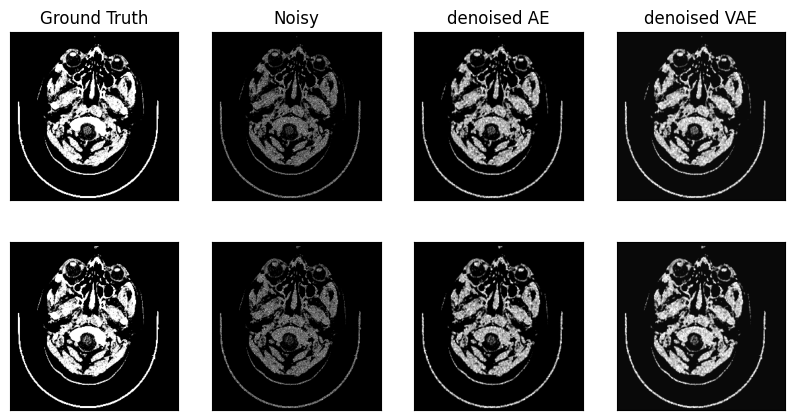

In [57]:
vmax=1
vmin = 0.0
fig, ax = plt.subplots(2,4,figsize=(10,5))
for i in range(0,2):
    ax[i,0].imshow(X_test_show[i+16,:,:],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,0].set_xticks([]);
    ax[i,0].set_yticks([]);
    ax[i,1].imshow(y_test_show[i+16,:,:],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,1].set_xticks([]);
    ax[i,1].set_yticks([]);
    ax[i,2].imshow(predict[i+16,:,:],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,2].set_xticks([]);
    ax[i,2].set_yticks([]);
    ax[i,3].imshow(predict2[i+16,:,:],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,3].set_xticks([]);
    ax[i,3].set_yticks([]);
ax[0,0].set_title('Ground Truth');
ax[0,1].set_title('Noisy');
ax[0,2].set_title('denoised AE');
ax[0,3].set_title('denoised VAE');
# Notes: you don't have to follow this structure as long as you can build the network correctly
print('PSNR before: %s' % peak_signal_noise_ratio(X_test_show[:,:,:],y_test_show[:,:,:]))
print('PSNR after AE: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising
print('PSNR after VAE: %s' % peak_signal_noise_ratio(X_test_show,predict2)) # Note: Show the average PSNR before and after denoising
fig.savefig('Test_0-1.png')

PSNR before: 16.591647385625798
PSNR after AE: 23.94026946650539
PSNR after VAE: 20.96901333446926


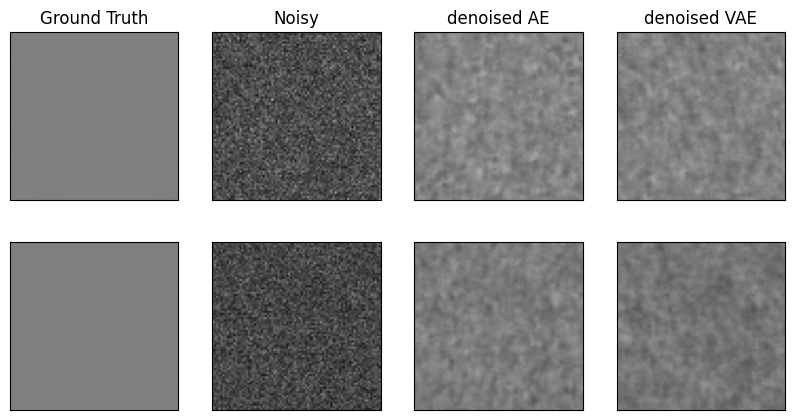

In [23]:
vmax=1
vmin = 0.0
idx1 = int(np.floor(256/2)-40)
idx2 = int(np.floor(256/2)+40)
fig, ax = plt.subplots(2,4,figsize=(10,5))
for i in range(0,2):
    ax[i,0].imshow(X_test_show[i+16,idx1:idx2,idx1:idx2],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,0].set_xticks([]);
    ax[i,0].set_yticks([]);
    ax[i,1].imshow(y_test_show[i+16,idx1:idx2,idx1:idx2],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,1].set_xticks([]);
    ax[i,1].set_yticks([]);
    ax[i,2].imshow(predict[i+16,idx1:idx2,idx1:idx2],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,2].set_xticks([]);
    ax[i,2].set_yticks([]);
    ax[i,3].imshow(predict2[i+16,idx1:idx2,idx1:idx2],cmap='gray',vmax=vmax,vmin=vmin);
    ax[i,3].set_xticks([]);
    ax[i,3].set_yticks([]);
ax[0,0].set_title('Ground Truth');
ax[0,1].set_title('Noisy');
ax[0,2].set_title('denoised AE');
ax[0,3].set_title('denoised VAE');
# Notes: you don't have to follow this structure as long as you can build the network correctly
print('PSNR before: %s' % peak_signal_noise_ratio(X_test_show[:,:,:],y_test_show[:,:,:]))
print('PSNR after AE: %s' % peak_signal_noise_ratio(X_test_show,predict)) # Note: Show the average PSNR before and after denoising
print('PSNR after VAE: %s' % peak_signal_noise_ratio(X_test_show,predict2)) # Note: Show the average PSNR before and after denoising
fig.savefig('Test_0-2.png')

In [89]:
AE = nib.load('C:/Users/wnewm/NeuralNetworks_python/Clipped/B'+str(B)+'/VAE/'+ st)
AE = np.array(AE.get_fdata())
AE.shape
np.max(AE)

1.0

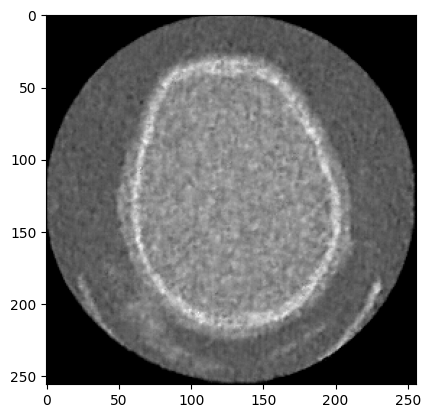

In [22]:
plt.imshow(AE[16,:,:],cmap='gray')

In [90]:
from ipywidgets import widgets, interact, IntSlider
def view_slice(slice_index):
    plt.figure(figsize=(4, 4))

    plt.imshow(volume[slice_index,:,:], cmap='gray')
    plt.axis('off')
    plt.title(f'Slice {slice_index + 1}')
    plt.show()
volume = AE
# Slider to select the slice index
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=volume.shape[0] - 1,  # max slice index
    step=1,
    description='Slice Index:',
    continuous_update=True
)
# Use ipywidgets' interactive functionality to bind the slider and the display function
widgets.interactive(view_slice, slice_index=slice_slider)

interactive(children=(IntSlider(value=0, description='Slice Index:', max=300), Output()), _dom_classes=('widge…